# Improvements

## **Motivation**

* The performance of the MLP baseline can be improved by increasing the number of hidden layers, or number of neurons in a layer.
* The MLP baseline was also overfitting so we can add regularization using dropout technique. 

## Description

To address the problem, we added another hidden layer of 500 neurons followed by a ReLU non-linear activation. We are not using dropout as this might actually harm the performance as the available dataset is small.

## Architecture
![label_ss](./images/mlp_improvement.png)


## Implementation

In [1]:
import sys
sys.path.append("..")

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
import numpy as np
import torchvision
import torchvision.transforms as transforms
import tqdm
from torch.utils.data import Dataset
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import os
from src.dataset import *
from src.utils import *
import torch.optim as optim

import matplotlib
from torch.utils.data import DataLoader

### Model definition

In [3]:
class mlp(nn.Module):

    def __init__(self, input_size, hidden_size1, hidden_size2,  output_size):
        super(mlp , self).__init__()
        # LL1:   3 x 144 x 256 = 110592 -->  500
        self.layer1 = nn.Linear(  input_size   , hidden_size1  )
        # LL2:   500 -->  500
        self.layer2 = nn.Linear(  hidden_size1 , hidden_size2  )
        # LL3:   500 -->  6
        self.layer3 = nn.Linear(  hidden_size2 , output_size  ) 
        
        
    def forward(self, x):
        # LL1:   3 x 144 x 256 = 110592 -->  500
        x = x.view(-1, 110592)
        y       = self.layer1(x)
        y_hat   = F.relu(y)
        # LL2:   500 -->  500
        z       = self.layer2(y_hat)
        z_hat   = F.relu(z)
        # LL3:   500 -->  6
        scores  = self.layer3(z_hat)
        
        return scores

In [4]:
# training function
def train(model, dataloader, optimizer, criterion, train_data, device):
    print("Training")
    model.train()
    counter = 0
    train_running_loss = 0.0
    train_running_error = 0.0
    for i, data in tqdm(
        enumerate(dataloader), total=int(len(train_data) / dataloader.batch_size)
    ):
        
        counter += 1
        data, target = data["image"].to(device), data["label"].to(device)
        optimizer.zero_grad()
        outputs = model(data)
        # apply sigmoid activation to get all the outputs between 0 and 1
        outputs = torch.sigmoid(outputs)
        loss = criterion(outputs, target)
        train_running_loss += loss.detach().item()
        error = get_error( outputs.detach() , target, batch_size)
        train_running_error += error
        
        # backpropagation
        loss.backward()
        # update optimizer parameters
        optimizer.step()

        
    train_loss = train_running_loss / counter
    total_error = train_running_error/counter
    return train_loss, total_error

In [5]:
def validate(model, dataloader, criterion, val_data, device):
    print("Validating")
    model.eval()
    counter = 0
    val_running_loss = 0.0
    val_running_error = 0.0
    with torch.no_grad():
        for i, data in tqdm(
            enumerate(dataloader), total=int(len(val_data) / dataloader.batch_size)
        ):
            counter += 1
            data, target = data["image"].to(device), data["label"].to(device)
            outputs = model(data)
            # apply sigmoid activation to get all the outputs between 0 and 1
            outputs = torch.sigmoid(outputs)
            loss = criterion(outputs, target)
            val_running_loss += loss.item()
            error = get_error( outputs, target, batch_size)
            val_running_error += error
        val_loss = val_running_loss / counter
        val_error = val_running_error / counter
    return val_loss, val_error

### Model instantiation

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = 110592
hidden_size1 = 500
hidden_size2 = 500
output_size = 6
model = mlp(input_size, hidden_size1,hidden_size2,output_size)

model = model.to(device)
print(model)
display_num_param(model)
lr = 0.0001
epochs = 10
batch_size = 32
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCELoss()
# criterion = nn.BCEWithLogitsLoss()

mlp(
  (layer1): Linear(in_features=110592, out_features=500, bias=True)
  (layer2): Linear(in_features=500, out_features=500, bias=True)
  (layer3): Linear(in_features=500, out_features=6, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
There are 55550006 (55.55 million) parameters in this neural network


### Data Loading

In [8]:
# train dataset
train_data = ImageDataset(train=True)
# validation dataset
valid_data = ImageDataset(train=False)
# train data loader
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
# validation data loader
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False)



Number of training images: 2065
Number of test images: 365


### Train

In [9]:
train_loss = []
valid_loss = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss, total_epoch_error = train(
        model, train_loader, optimizer, criterion, train_data, device
    )
    valid_epoch_loss, valid_epoch_error = validate(model, valid_loader, criterion, valid_data, device)
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print("Train Error: ", total_epoch_error)
    print(f"Val Loss: {valid_epoch_loss:.4f}")
    print(f"Val Error: ", valid_epoch_error)
    

Epoch 1 of 10
Training


65it [00:04, 15.77it/s]                                                                                                


Validating


12it [00:00, 23.78it/s]                                                                                                


Train Loss: 0.4621
Train Error:  20.616987748787952
Val Loss: 0.6461
Val Error:  25.824653605620068
Epoch 2 of 10
Training


65it [00:02, 28.24it/s]                                                                                                


Validating


12it [00:00, 29.35it/s]                                                                                                


Train Loss: 0.3451
Train Error:  14.487179953318376
Val Loss: 0.6371
Val Error:  28.60243146618207
Epoch 3 of 10
Training


65it [00:02, 29.27it/s]                                                                                                


Validating


12it [00:00, 29.35it/s]                                                                                                


Train Loss: 0.2746
Train Error:  10.833333616073315
Val Loss: 0.7073
Val Error:  27.300348008672398
Epoch 4 of 10
Training


65it [00:02, 28.52it/s]                                                                                                


Validating


12it [00:00, 29.86it/s]                                                                                                


Train Loss: 0.2270
Train Error:  8.774038690787096
Val Loss: 0.6911
Val Error:  26.041667411724728
Epoch 5 of 10
Training


65it [00:02, 28.77it/s]                                                                                                


Validating


12it [00:00, 27.16it/s]                                                                                                


Train Loss: 0.1858
Train Error:  6.6586540180903215
Val Loss: 0.7359
Val Error:  27.300348008672398
Epoch 6 of 10
Training


65it [00:02, 28.30it/s]                                                                                                


Validating


12it [00:00, 29.49it/s]                                                                                                


Train Loss: 0.1645
Train Error:  5.961538639206153
Val Loss: 0.8059
Val Error:  32.1180564040939
Epoch 7 of 10
Training


65it [00:02, 28.49it/s]                                                                                                


Validating


12it [00:00, 29.64it/s]                                                                                                


Train Loss: 0.1258
Train Error:  4.054487296738303
Val Loss: 0.7741
Val Error:  26.95312574505806
Epoch 8 of 10
Training


65it [00:02, 28.70it/s]                                                                                                


Validating


12it [00:00, 29.27it/s]                                                                                                


Train Loss: 0.1116
Train Error:  3.557692405839379
Val Loss: 0.8814
Val Error:  28.472223474333685
Epoch 9 of 10
Training


65it [00:02, 28.26it/s]                                                                                                


Validating


12it [00:00, 26.86it/s]                                                                                                


Train Loss: 0.1068
Train Error:  3.3894231958458056
Val Loss: 0.9533
Val Error:  28.819445023934048
Epoch 10 of 10
Training


65it [00:02, 27.85it/s]                                                                                                


Validating


12it [00:00, 27.98it/s]                                                                                                

Train Loss: 0.0737
Train Error:  2.0272436544585686
Val Loss: 0.9969
Val Error:  29.123264426986378


### Test

In [12]:
actors = np.array(CLASSES)
print('actors: ', actors)
# prepare the test dataset and dataloader
test_data = ImageDataset(train=False)
test_loader = DataLoader(test_data, batch_size=1, shuffle=True)

actors:  ['chandler' 'joey' 'monica' 'phoebe' 'rachel' 'ross']
Number of test images: 365


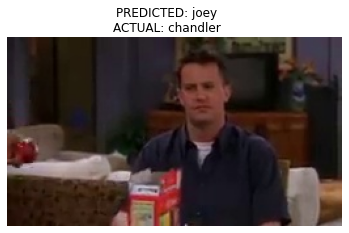

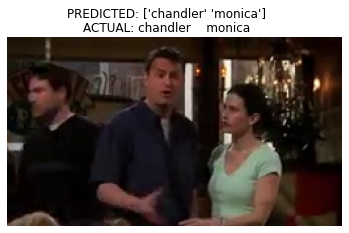

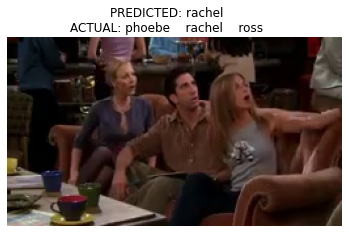

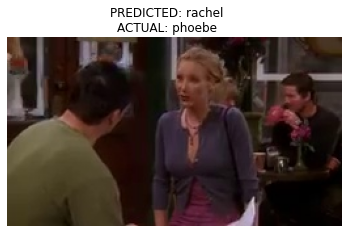

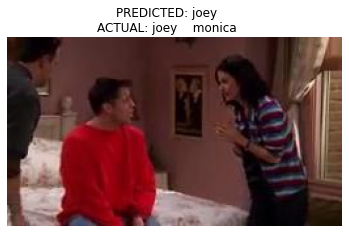

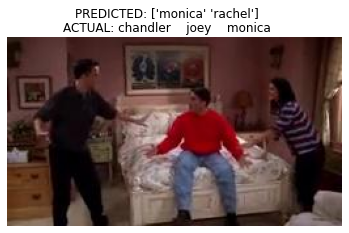

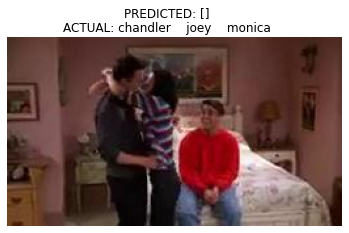

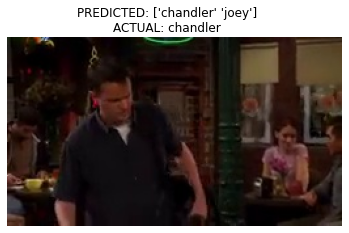

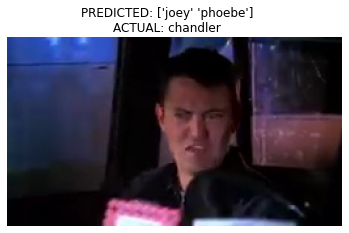

Test Error:  30.723443832043763


In [15]:
model.eval()
test_running_error = 0.0
output_list= []
target_list = []
for counter, data in enumerate(test_loader):
    
    image, target = data["image"].to(device), data["label"]
    # get all the index positions where value == 1
    target_indices = [i for i in range(len(target[0])) if target[0][i] == 1]

    # get the predictions by passing the image through the model
    outputs = model(image)
    outputs = torch.sigmoid(outputs)
    outputs = outputs.detach().cpu()
    lab = torch.where(outputs>=0.5,1,0)[0]
    pred = torch.where(lab==1)
    error = get_error( outputs, target, 1)
    
    output_list.append(outputs.numpy())
    target_list.append(target.numpy())
    
    test_running_error += error
    
    string_predicted = ""
    string_actual = ""
    for i in range(len(pred)):
        string_predicted += f"{actors[pred[i]]}    "
    for i in range(len(target_indices)):
        string_actual += f"{actors[target_indices[i]]}    "
        
    if 10< counter < 20:
        image = image.squeeze(0)
        image = image.detach().cpu().numpy()
        image = np.transpose(image, (1, 2, 0))
        plt.imshow(image)
        plt.axis("off")
        plt.title(f"PREDICTED: {string_predicted}\nACTUAL: {string_actual}")
        plt.show()
    
test_error = test_running_error / counter
print(f"Test Error: ", test_error)

out = np.array(output_list).squeeze(axis=1)
tar = np.array(target_list).squeeze(axis=1)



In [16]:
f1 = get_f1_score(tar, out)
precision = get_precision_score(tar, out)
recall = get_recall_score(tar, out)
print("f1 score: ", f1)
print('Precision: ', precision)
print('Recall: ', recall)

f1 score:  0.3063470319634703
Precision:  0.3570776255707762
Recall:  0.30333333333333334


C:\Users\Rishabh\anaconda3\envs\deeplearn_course\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Results

For an MLP with two hidden layer of 500 neurons, the below are the results after training for 10 epocs:

* Train Loss: 0.0737
* Train Error:  2.0272436544585686
* Val Loss: 0.9969
* Val Error:  29.123264426986378
* We observe that the Train Loss and Train error decreases after each epoch. However, the Validation error may increase or decrease after each epoch (overfitting). However, the Validation error has improved from the performance of MLP baseline.
* Test Error:  30.723443832043763
* F1 score:  0.3063470319634703
* Precision:  0.3570776255707762
* Recall:  0.30333333333333334
* The Test error is 30.723% and we have a F1 score of 0.3063
* Learnable Parameters: 55.50 million

## Discussion

* The MLP Improvement model performs better than the baseline. The better F1 score and Test error of the MLP Improvement model confirms it. This is because there is an added hidden layer that increase the total learnable parameters to 55.55 million.
* The performance can still be improved with more data, or making a deeper network with more neurons. As the nunmber of learnable parameters increase, the performance of the model imrpoves. However, this may also cause the model to overfit on such a small dataset. Hence, having a larger dataset would helpl in reducing overfitting and improve the performance on test data.

